In [8]:
from pathlib import Path
import pandas as pd
import gzip
import json 

data = []
for path in Path('1551.gov.ua/raw').rglob('*.gz'):
    with gzip.open(path, 'rt', encoding='utf-8') as f:
        request = json.load(f)
        r = {
            'text': request[0]['CallZText'],
            'label': request[0]['CallZType'],                 
        }
        data.append(r)
        
df = pd.DataFrame(data, columns=['text', 'label'])

### Препроцесінг даних

In [9]:
df = df[df['text'].map(len) != 0]

In [10]:
# Заміна лапок для векторизатора
df['text'] = df['text'].str.replace(r"’", "'")

### Зменшення кількості категорій

#### Спроба 1

In [11]:
print("Загальна кількість категорій:" ,len(df['label'].unique()))

Загальна кількість категорій: 918


In [12]:
df['label'] = df['label'].str.replace("’", "'")
df['label'] = df['label'].str.replace("ГВП", "гаряча вода")
df['label'] = df['label'].str.replace("ХВП", "холодна вода")
df['label'] = df['label'].str.replace("АЗС", "автомобільно заправочна станція")
df['label'] = df['label'].str.replace("дооблаштування", "покращення")
df['label'] = df['label'].str.replace("благоуст", "благоустрій")


In [10]:
import re

def get_sent_vec (sentence):
    sentence_vectors = []
    
    for i, token in enumerate(sentence):
        if re.search(r'\w', token):
            lemma = morph.parse(token)[0].normal_form
            vec = uk(lemma).vector
            sentence_vectors.append(vec)
        
    return np.mean(sentence_vectors, axis=0).tolist()

In [29]:
import spacy 
import pymorphy2
import numpy as np

uk = spacy.load("/tmp/uk_vectors")
morph = pymorphy2.MorphAnalyzer(lang='uk')

In [12]:
import tokenize_uk

df["label_tokenized"] = df['label'].apply(tokenize_uk.tokenize_uk.tokenize_words)
df["label_tokenized"] = df["label_tokenized"].apply(lambda x: [token.lower() for token in x])
df["labels_vec"] = df['label_tokenized'].apply(get_sent_vec)

In [13]:
from collections import defaultdict
from sklearn.cluster import KMeans

def clusterize (labels, cluster_num):
    kmeans = KMeans(n_clusters=cluster_num, random_state=0).fit(labels.to_list())
    clusters = kmeans.labels_
    clusters_dict = defaultdict(set)

    for i, cluster in enumerate(clusters):
        clusters_dict[cluster].add(df['label'].iloc[i])
    return clusters_dict

clusters = clusterize(df["labels_vec"], 200)
list(clusters.items())[15:20]

[(129,
  {'@ Викошування газонів мотокосаркою',
   'Полив клумб і газонів, дерев, кущів, зелених газонів'}),
 (4,
  {'Відсутність або незадовільний стан плафонів на опорних стовпах',
   'Відсутність освітлення на опорних стовпах за відсутності/несправності лампочок'}),
 (92,
  {'Обслуговування та утримання кабельних мереж',
   'Обслуговування трансформаторної підстанції',
   'Ремонт та обслуговування водостічних труб',
   'Ремонт та обслуговування зливневих стоків'}),
 (3, {'Ремонт дахів'}),
 (1,
  {'@ Плата для заїзду автотранспорту на кладовища міста',
   'Безкоштовний проїзд окремих категорій громадян',
   'Безоплатний проїзд по «Картці киянина» в Київському  метрополітені',
   'Відмова в безкоштовному перевезенні пасажирів пільгових категорій марш. таксі',
   'Зупинки на вимогу маршрутних таксі',
   'Не видача пасажирам квитків (марш. таксі)',
   'Оплата проїзду в міській електричці',
   'Право безкоштовного проїзду всіма видами пасажирського міського транспорту',
   'Про заробітну

#### Спроба 2

In [14]:
label_counts = df['label'].value_counts()
label_counts = label_counts[label_counts > 100]
df = df[df['label'].isin(label_counts.index)].reset_index(drop=True)

In [15]:
clusters = clusterize(df["labels_vec"], 100)
list(clusters.items())[10:20]

[(9, {'Незадовільна температура гаряча вода'}),
 (5, {'Відсутність опалення'}),
 (26,
  {'Вирізування (кронування) гілля дерев',
   'Полив клумб і газонів, дерев, кущів, зелених газонів',
   'Прибирання дерев, гілок, листя з закріпленої території',
   'Садіння нових дерев і кущів',
   'Скошування трави'}),
 (93,
  {'Відсутність опори освітлення (не передбачено проектом забудови)',
   'Відсутність освітлення на опорних стовпах за відсутності/несправності лампочок'}),
 (88,
  {'Культура обслуговування пасажирів маршрутних таксі',
   'Обслуговування димовентиляційних каналів',
   'Ремонт та обслуговування водостічних труб',
   'Ремонт та обслуговування зливневих стоків',
   'Ремонт та обслуговування конструкцій фризу (козирок);',
   'Ремонт та обслуговування ґанків'}),
 (24, {'Ремонт дахів'}),
 (33,
  {"Відновлення благоустрійрою після вик. планових,аварійних робіт на об'єктах благоустрій",
   "Порушення правил виконання (ор-ції) будівельних робіт на об'єктах благоустрійрою"}),
 (13,
  {'

In [20]:
top10 = df['label'].value_counts()[:10].index.to_list()
df = df[(df.text != '') & df.label.isin(top10)]
df

,text,label
1,Почему опять нет горячей воды? Я видел что за ...,Відсутність гаряча вода
2,"не має гарячої води, замість гарячої - холодна...",Відсутність гаряча вода
5,На прибудинковій території не прибирається.,Прибирання та санітарний стан територій
12,На 15-м этаже возле лифтовой площадки перегоре...,Відсутність освітлення у під'їзді за відсутнос...
13,На сегодняшний день 14 октября 2014 г. в нашем...,Відсутність гаряча вода
17,В Жилом доме по указанному адресу 2 месяца нет...,Відсутність гаряча вода
18,Прошу звернути увагу та вжити всіх необхідних ...,Відсутність гаряча вода
19,"ГВП неналежної якості.\r\n\r\nНаразі вода, що ...",Незадовільна температура гаряча вода
20,обращаемся от имени родителей учеников музыкал...,Відсутність опалення
22,Скаргою від 22.10.2013 №І-4751 було повідомлен...,Відсутність гаряча вода


### Бейзлайн

In [48]:
import spacy 
import pymorphy2
import numpy as np

uk = spacy.load("/tmp/uk_vectors")
morph = pymorphy2.MorphAnalyzer(lang='uk')

In [30]:
import tokenize_uk

df["tokenized"] = df['text'].apply(tokenize_uk.tokenize_uk.tokenize_words)
df["tokenized"] = df["tokenized"].apply(lambda x: [token.lower() for token in x])
df["sent_vec"] = df['tokenized'].apply(get_sent_vec)

In [52]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(df['sent_vec'], df['label'], test_size=0.3, random_state=42)
print("Довжина тренувальної вибірки", len(train_data))
print("Довжина тестувальної вибірки ", len(test_data))

Довжина тренувальної вибірки 79815
Довжина тестувальної вибірки  34207


In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
    
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_data.to_list(), train_labels.to_list())
pred = neigh.predict(test_data.to_list())
print(classification_report(pred, test_labels))

                                                                                              precision    recall  f1-score   support

                                                                                 Інші Подяки       0.22      0.33      0.26        97
                                                          Інші технічні недоліки стану ліфту       0.43      0.14      0.21      1244
                      Аварійний, травмонебезпечний стан утримання об'єктів благоустрійрійрою       0.19      0.09      0.12       282
                                                  Будівництво/покращення дитячого майданчику       0.61      0.26      0.36       789
                                            Видалення аварійних, пошкоджених хворобами дерев       0.40      0.27      0.32       259
                                                                  Вилов безпритульних тварин       0.65      0.53      0.59        86
                                                        Виріз

### Покращення бейзлайну

In [24]:
%%time 

from langdetect import detect

df['lang'] = df['text'].apply(detect)
print(df['lang'].value_counts())
df = df[df.lang == 'uk'].reset_index(drop=True)

uk    61627
ru    51877
bg      381
mk      127
de        4
pl        3
en        2
sl        1
Name: lang, dtype: int64
CPU times: user 9min 6s, sys: 21.7 s, total: 9min 27s
Wall time: 9min 28s


In [31]:
%%time 

from langdetect import detect

df['lang'] = df['text'].apply(detect)
print(df['lang'].value_counts())
df = df[df.lang == 'uk'].reset_index(drop=True)

uk    23709
ru    20865
bg      189
mk       56
de        3
en        2
pl        2
et        1
Name: lang, dtype: int64
CPU times: user 3min 23s, sys: 8.45 s, total: 3min 32s
Wall time: 3min 32s


In [32]:
with open('stopwords.txt', 'r') as f:
    stopwords = set(f.read().splitlines())

In [33]:
import re

def preprocess_text (text):
    result = []
    for word in text:
        # видаляю числа, пунктуацію, знаки
        if word not in stopwords and re.search(r'^[А-яєіїЄІЇ\']+$', word):
            result.append(word.lower())
    return result
    
df['tokenized'] = df['tokenized'].apply(preprocess_text)

In [34]:
df = df[df['tokenized'].map(len) != 0]

In [ ]:
%%time
df["sent_vec"] = df['tokenized'].apply(get_sent_vec)

In [32]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(df['sent_vec'], df['label'], test_size=0.3, random_state=42)
print("Довжина тренувальної вибірки", len(train_data))
print("Довжина тестувальної вибірки ", len(test_data))

Довжина тренувальної вибірки 43136
Довжина тестувальної вибірки  18487


In [49]:
from sklearn.metrics import f1_score

for i in range(1, 10):
    neigh = KNeighborsClassifier(n_neighbors=i, n_jobs = -1)
    neigh.fit(train_data.to_list(), train_labels.to_list())
    pred = neigh.predict(test_data.to_list())
    f1 = f1_score(pred, test_labels, average = "macro")
    print(f'Якщо К = {i}, F1 = {f1}')

Якщо К = 1, F1 = 0.34476919455175675
Якщо К = 2, F1 = 0.2782469404767038
Якщо К = 3, F1 = 0.27391981372403373


/Users/valeria/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.


Якщо К = 4, F1 = 0.27307104998613896
Якщо К = 5, F1 = 0.2756744920290285
Якщо К = 6, F1 = 0.27407467889236403
Якщо К = 7, F1 = 0.27828542139134305
Якщо К = 8, F1 = 0.2713585153703533
Якщо К = 9, F1 = 0.27107989407631516


In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

    
neigh = KNeighborsClassifier(n_neighbors=1, n_jobs = -1)
neigh.fit(train_data.to_list(), train_labels.to_list())
pred = neigh.predict(test_data.to_list())
print(classification_report(pred, test_labels))

                                                                                        precision    recall  f1-score   support

                                                                           Інші Подяки       0.09      0.43      0.15        21
                                                    Інші технічні недоліки стану ліфту       0.39      0.33      0.36       230
                   Аварійний, травмонебезпечний стан утримання об'єктів благоустрійрою       0.23      0.29      0.26        65
                                                Бажаючі отримати ”Картки киянина (КК)”       0.40      0.80      0.53        10
                                        Будівництво /покращення спортивних майданчиків       0.24      0.21      0.23        28
                                           Будівництво автомобільно заправочна станція       0.29      0.36      0.32        25
                                                              Будівництво в нічний час       0.13      

### Fasttext

In [22]:
import fasttext
import fasttext.util

ft = fasttext.load_model('cc.uk.300.bin')

In [23]:
def get_sent_vec (sentence):
    sentence_vectors = []
    
    for i, token in enumerate(sentence):
        if re.search(r'\w', token):
            lemma = morph.parse(token)[0].normal_form
            vec = ft[lemma]
            sentence_vectors.append(vec)
        
    return np.mean(sentence_vectors, axis=0).tolist()

In [35]:
df["sent_vec"] = df['tokenized'].apply(get_sent_vec)

In [61]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(df['sent_vec'], df['label'], test_size=0.3, random_state=42)
print("Довжина тренувальної вибірки", len(train_data))
print("Довжина тестувальної вибірки ", len(test_data))

Довжина тренувальної вибірки 39561
Довжина тестувальної вибірки  16955


In [62]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

    
neigh = KNeighborsClassifier(n_neighbors=1, n_jobs = -1)
neigh.fit(train_data.to_list(), train_labels.to_list())
pred = neigh.predict(test_data.to_list())
print(classification_report(pred, test_labels))

                                                                                              precision    recall  f1-score   support

                                                                                 Інші Подяки       0.10      0.38      0.16        26
                                                          Інші технічні недоліки стану ліфту       0.48      0.39      0.43       248
                      Аварійний, травмонебезпечний стан утримання об'єктів благоустрійрійрою       0.17      0.22      0.19        67
                                                  Будівництво/покращення дитячого майданчику       0.57      0.43      0.49       245
                                            Видалення аварійних, пошкоджених хворобами дерев       0.41      0.42      0.41        92
                                                                  Вилов безпритульних тварин       0.51      0.81      0.63        27
                                                        Виріз

#### Результати для класифікації на 10 класів

In [36]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(df['sent_vec'], df['label'], test_size=0.3, random_state=42)
print("Довжина тренувальної вибірки", len(train_data))
print("Довжина тестувальної вибірки ", len(test_data))

Довжина тренувальної вибірки 16594
Довжина тестувальної вибірки  7112


In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

    
neigh = KNeighborsClassifier(n_neighbors=1, n_jobs = -1)
neigh.fit(train_data.to_list(), train_labels.to_list())
pred = neigh.predict(test_data.to_list())
print(classification_report(pred, test_labels))

                                                                                        precision    recall  f1-score   support

Відновлення благоустрійрою після вик. планових,аварійних робіт на об'єктах благоустрій       0.40      0.36      0.37       441
                                                               Відсутність гаряча вода       0.78      0.73      0.75      2080
                                                                  Відсутність опалення       0.60      0.66      0.63       835
                Відсутність освітлення у під'їзді за відсутності/несправності лампочок       0.63      0.77      0.70       301
                                                           Не працює пасажирський ліфт       0.84      0.84      0.84       341
                                                  Незадовільна температура гаряча вода       0.58      0.45      0.51       429
                           Перевірка дозвільної документації, демонтаж кіосків, ларків       0.77      

### Візуалізація

In [61]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 185))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [70]:
digits_proj = TSNE(random_state=1, n_jobs=-1, n_components=3).fit_transform(test_data.to_list())

/Users/valeria/anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:902: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


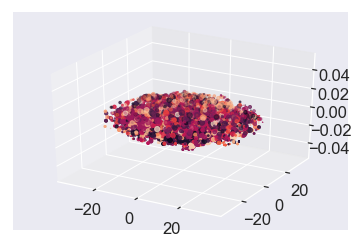

In [96]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm


colors = np.hstack([l.index(label) for label in test_labels])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plt.scatter(*zip(*digits_proj), c=colors)
plt.show()

In [97]:
digits_proj = TSNE(random_state=1, n_jobs=-1, n_components=2).fit_transform(test_data.to_list())

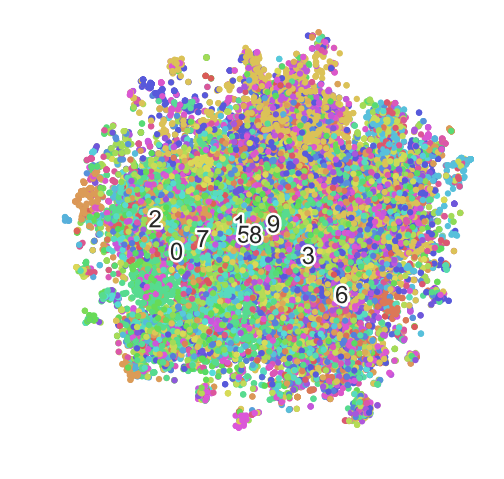

In [98]:
scatter(digits_proj, colors)
plt.show()